# **Lab 6**

## **Question-1: [Principal Component Analysis] :- [60 marks]**
In 1990 David, Sterling and Wray Buntine donated an Annealing Dataset in order to study Steel
Annealing(a heat treatment that alters the physical and sometimes chemical properties of a material).
Classes (1,2,3,4,5,U) hereby act as Label and other parameters as Input Features.


1. From the given link, download “anneal.data”, “anneal.names” and “anneal.test”, convert them
into a readable format (Ex: txt, csv, etc....) and do meaningful Exploratory Data Analysis. [5 Marks]


In [ ]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 6/anneal.data',header=None)
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 6/anneal.test',header=None)

cols = ['family', 'product-type', 'steel', 'carbon', 'hardness', 'temper_rolling', 'condition', 'formability', 'strength', 'non-ageing', 'surface-finish', 'surface-quality', 'enamelability', 'bc', 'bf', 'bt', 'bw/me', 'bl', 'm', 'chrom', 'phos', 'cbond', 'marvi', 'exptl', 'ferro', 'corr', 'blue/bright/varn/clean', 'lustre', 'jurofm', 's', 'p', 'shape', 'thick', 'width', 'len', 'oil', 'bore', 'packing', 'class']
df.columns = cols
df_test.columns = cols


2. Preprocess the data (If any discrepancies/errors, handle them as well) and split the data into
[65:35]. [4 + 1 Marks]


In [ ]:
LE = preprocessing.LabelEncoder()
conts = ['carbon','hardness','strength','thick','width','len']
need_to_be_dropped = ['surface-finish','enamelability','bc','phos','exptl','blue/bright/varn/clean','packing']

for f in df.columns[:-1]:
    if f not in conts:
        if len(np.unique(df[f]))==1:
            need_to_be_dropped.append(f)
            continue
        df[f]=LE.fit_transform(df[f])
        df_test[f]=LE.fit_transform(df_test[f])
    
df.drop(need_to_be_dropped,inplace=True,axis=1)
df_test.drop(need_to_be_dropped,inplace=True,axis=1)

Y = df['class']
X = df.drop(['class'],axis=1)


X_train, X_val, Y_train, Y_val = tts(X,Y,test_size=0.35,stratify=Y)


3. Train 2-3 Classification Models (studied and implemented so far) with the proper reasoning of
choosing them and show 5-Fold Cross-Validation Plots as well for comparison. [5 + 5 Marks]

Accuracy Scores : 

Accuracy = 98.21 %	[ Decision Tree Classifier ]
Accuracy = 98.57 %	[ XGBoost Classifier ]
Accuracy = 98.93 %	[ Random Forest Classifier ]



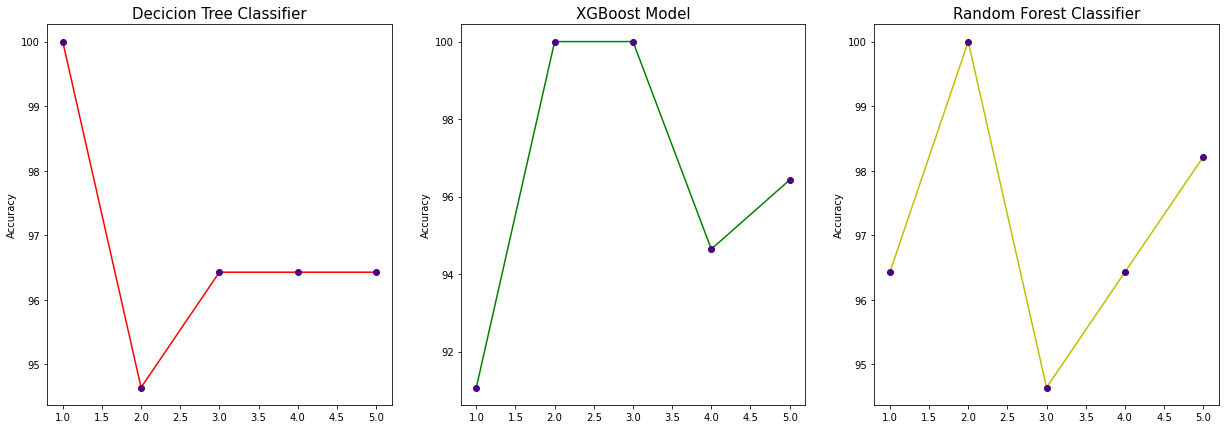

In [163]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc_model = DTC()
dtc_preds = dtc_model.fit(X_train,Y_train).predict(X_val)
dtc_acc = metrics.accuracy_score(Y_val, dtc_preds)

from xgboost import XGBClassifier as XGB
xgb_model = XGB()
xgb_preds = xgb_model.fit(X_train,Y_train).predict(X_val)
xgb_acc = metrics.accuracy_score(Y_val, xgb_preds)

from sklearn.ensemble import RandomForestClassifier as RFC
rfc_model = RFC()
rfc_preds = rfc_model.fit(X_train,Y_train).predict(X_val)
rfc_acc = metrics.accuracy_score(Y_val,rfc_preds)

print('Accuracy Scores : \n')
print(f'Accuracy = {dtc_acc*100:.2f} %\t[ Decision Tree Classifier ]')
print(f'Accuracy = {xgb_acc*100:.2f} %\t[ XGBoost Classifier ]')
print(f'Accuracy = {rfc_acc*100:.2f} %\t[ Random Forest Classifier ]\n')

cv_scores = [[],[],[]]
cv_scores[0] = np.array(model_selection.cross_val_score(dtc_model, X_val, Y_val, cv=model_selection.KFold(5,shuffle=True), scoring='accuracy'))*100
cv_scores[1] = np.array(model_selection.cross_val_score(xgb_model, X_val, Y_val, cv=model_selection.KFold(5,shuffle=True), scoring='accuracy'))*100
cv_scores[2] = np.array(model_selection.cross_val_score(rfc_model, X_val, Y_val, cv=model_selection.KFold(5,shuffle=True), scoring='accuracy'))*100


plt.figure(figsize=(21,7))
titles=['Decicion Tree Classifier','XGBoost Model','Random Forest Classifier']
colors=['r','g','y']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(titles[i],fontsize=15)
    plt.plot(range(1,6), cv_scores[i],colors[i])
    plt.plot(range(1,6), cv_scores[i],color='indigo',marker='o',linestyle='')
    plt.ylabel('Accuracy')

plt.show()



4. Implement Principal Component Analysis from scratch, with sub-tasks as following:- [5 + 10
Marks] \
a. Centralize the Data via feature-wise means and standard deviations. Write the
code for deriving the covariance matrix from scratch. \
b. Make a function Singular_Value_Decomp from scratch in order to compute
Eigenvectors, Eigenvalues and Principal Components.


In [165]:
def transposeMatrix(m):
    return map(list,zip(*m))

def getMatrixMinor(m,i,j):
    return [row[:j] + row[j+1:] for row in (m[:i]+m[i+1:])]

def getMatrixDeternminant(m):
    if len(m) == 2:
        return m[0][0]*m[1][1]-m[0][1]*m[1][0]
    determinant = 0
    for c in range(len(m)):
        determinant += ((-1)**c)*m[0][c]*getMatrixDeternminant(getMatrixMinor(m,0,c))
    return determinant

def getMatrixInverse(m):
    determinant = getMatrixDeternminant(m)
    if len(m) == 2:
        return [[m[1][1]/determinant, -1*m[0][1]/determinant],
                [-1*m[1][0]/determinant, m[0][0]/determinant]]
    cofactors = []
    for r in range(len(m)):
        cofactorRow = []
        for c in range(len(m)):
            minor = getMatrixMinor(m,r,c)
            cofactorRow.append(((-1)**(r+c)) * getMatrixDeternminant(minor))
        cofactors.append(cofactorRow)
    cofactors = transposeMatrix(cofactors)
    for r in range(len(cofactors)):
        for c in range(len(cofactors)):
            cofactors[r][c] = cofactors[r][c]/determinant
    return np.array(cofactors)

def covar(X):
    N, M = X.shape
    cov = np.zeros((M, M))
    for i in range(M):
        mean_i = np.sum(X[:, i]) / N
        for j in range(M):
            mean_j = np.sum(X[:, j]) / N
            cov[i, j] = np.sum((X[:, i] - mean_i) * (X[:, j] - mean_j)) / (N - 1)
    return np.array(cov)

def centralize(X):
    X = preprocessing.StandardScaler().fit_transform(X)
    X = np.array(X)
    mu = np.mean(X,axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.0
    Xbar = (X - mu)/std_filled
    return Xbar

def Singular_Value_Decomp(X, n):
    S = covar(X)
    eigen_values, eigen_vectors = np.linalg.eig(S)
    idxs = np.argsort(abs(eigen_values))[::-1]
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]
    B = eigen_vectors[:, :n]
    P = B@(np.linalg.inv(B.T@B))@B.T
    return P,eigen_values,idxs
 
def PCA(X,P):
    X = (P @ X.T).T
    return X.real


5. Use the above-made PCA to reduce the data upto a chosen dimension/principal-components
and train 2-3 chosen classification models alongside 5-Fold Cross-Validation Plots. [5 + 5 Marks]


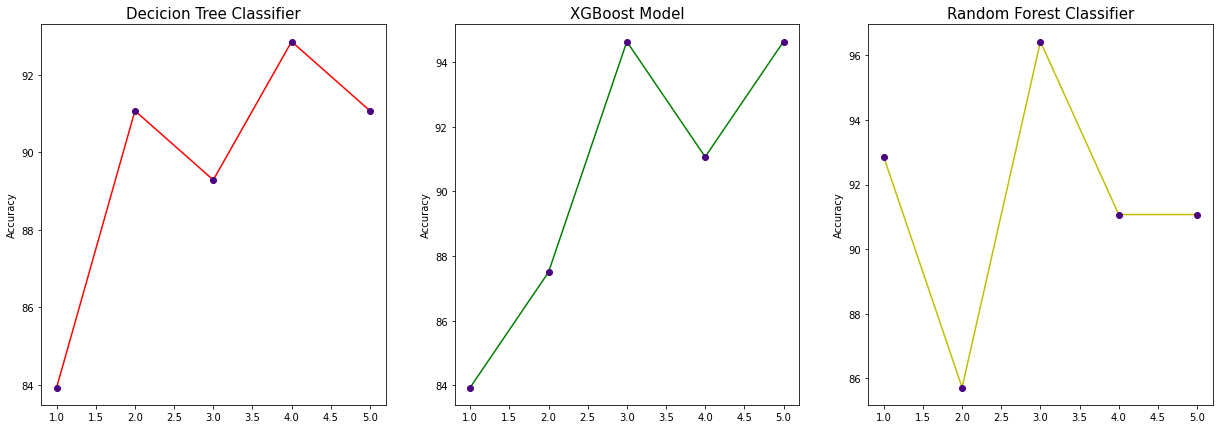

In [166]:
X_train_pca = centralize(X_train)
X_val_pca = centralize(X_val)
P,eigen_vals,idxs_pca = Singular_Value_Decomp(X_train_pca,5)  # P is Projection_matrix ( eigen vectors of Principal Components)
X_train_pca = PCA(X_train_pca,P)
X_val_pca = PCA(X_val_pca,P)

pca_model_dtc = DTC().fit(X_train_pca,Y_train)
pca_model_xgb = XGB().fit(X_train_pca,Y_train)
pca_model_rfc = RFC().fit(X_train_pca,Y_train)
cv_scores_pca = [[],[],[]]
cv_scores_pca[0] = np.array(model_selection.cross_val_score(pca_model_dtc, X_val_pca, Y_val, cv=model_selection.KFold(5,shuffle=True), scoring='accuracy'))*100
cv_scores_pca[1] = np.array(model_selection.cross_val_score(pca_model_xgb, X_val_pca, Y_val, cv=model_selection.KFold(5,shuffle=True), scoring='accuracy'))*100
cv_scores_pca[2] = np.array(model_selection.cross_val_score(pca_model_rfc, X_val_pca, Y_val, cv=model_selection.KFold(5,shuffle=True), scoring='accuracy'))*100

plt.figure(figsize=(21,7))
titles=['Decicion Tree Classifier','XGBoost Model','Random Forest Classifier']
colors=['r','g','y']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(titles[i],fontsize=15)
    plt.plot(range(1,6), cv_scores_pca[i],colors[i])
    plt.plot(range(1,6), cv_scores_pca[i],color='indigo',marker='o',linestyle='')
    plt.ylabel('Accuracy')

plt.show()


6. Show the Test results of Classification Models on both types of datasets (Before and After
PCA), via 2-3 Evaluation Metrics of choice (Ex:- Accuracy, Sensitivity, F1-Score, etc.) with the proper
reasonings. [5 + 5 Marks]


In [175]:
Y_test = df_test['class']
X_test = df_test.drop(['class'],axis=1)
X_test_pca = centralize(X_test)
X_test_pca = PCA(X_test_pca,P)

pca_preds_dtc = pca_model_dtc.predict(X_test_pca)
pca_preds_xgb = pca_model_xgb.predict(X_test_pca)
pca_preds_rfc = pca_model_rfc.predict(X_test_pca)

pca_dtc_acc = metrics.accuracy_score(Y_test, pca_preds_dtc)
pca_xgb_acc = metrics.accuracy_score(Y_test, pca_preds_xgb)
pca_rfc_acc = metrics.accuracy_score(Y_test, pca_preds_rfc)

print('Metrics on Testing Data after applying PCA\n')
print(f'Accuracy = {pca_dtc_acc*100:.2f} %\t[ Decision Tree Classifier ]')
print(f'Accuracy = {pca_xgb_acc*100:.2f} %\t[ XGBoost Classifier ]')
print(f'Accuracy = {pca_rfc_acc*100:.2f} %\t[ Random Forest Classifier ]\n')

print(f'Sensitivity for all classes = '+', '.join([str(round(x,4)) for x in metrics.recall_score(Y_test, pca_preds_dtc, average=None)])+ '\t[ Decision Tree Classifier ]')
print(f'Sensitivity for all classes = '+ ', '.join([str(round(x,4)) for x in metrics.recall_score(Y_test, pca_preds_xgb, average=None)]) +'\t[ XGBoost Classifier ]')
print(f'Sensitivity for all classes = '+ ', '.join([str(round(x,4)) for x in metrics.recall_score(Y_test, pca_preds_rfc, average=None)]) +'\t\t[ Random Forest Classifier ]\n')

print(f'F1 Score for all classes = '+', '.join([str(round(x,4)) for x in metrics.f1_score(Y_test, pca_preds_dtc, average=None)])+ '\t\t[ Decision Tree Classifier ]')
print(f'F1 Score for all classes = '+ ', '.join([str(round(x,4)) for x in metrics.f1_score(Y_test, pca_preds_xgb, average=None)]) +'\t[ XGBoost Classifier ]')
print(f'F1 Score for all classes = '+ ', '.join([str(round(x,4)) for x in metrics.f1_score(Y_test, pca_preds_rfc, average=None)]) +'\t\t[ Random Forest Classifier ]\n')

Metrics on Testing Data after applying PCA

Accuracy = 92.00 %	[ Decision Tree Classifier ]
Accuracy = 96.00 %	[ XGBoost Classifier ]
Accuracy = 96.00 %	[ Random Forest Classifier ]

Sensitivity for all classes = 0.8182, 0.9474, 0.8571, 0.8333	[ Decision Tree Classifier ]
Sensitivity for all classes = 1.0, 0.9737, 0.8571, 0.8333	[ XGBoost Classifier ]
Sensitivity for all classes = 1.0, 0.9737, 1.0, 0.6667		[ Random Forest Classifier ]

F1 Score for all classes = 0.8182, 0.96, 0.75, 0.8333		[ Decision Tree Classifier ]
F1 Score for all classes = 0.9565, 0.9737, 0.8571, 0.9091	[ XGBoost Classifier ]
F1 Score for all classes = 0.9565, 0.9737, 0.9333, 0.8		[ Random Forest Classifier ]




7. Were any changes observed before and after implementing PCA, with respect to the
distribution of the dataset? Also, make any suitable graph through which the optimal number of
principal components can be decided for optimal results. [2 + 3 Marks]

> Answer : We see that after losing a number of unuseful features, Accuracy of the models drops a bit for all the classifiers. However the overall accuracy of the models are good enough to predict values. (0.85 +)

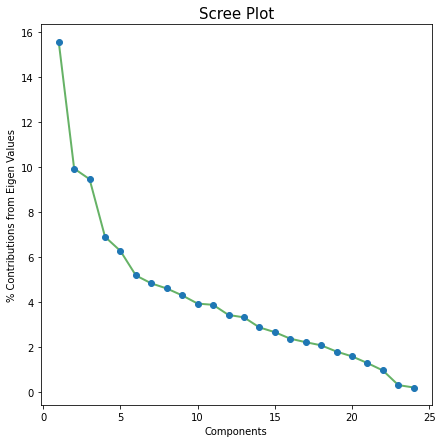

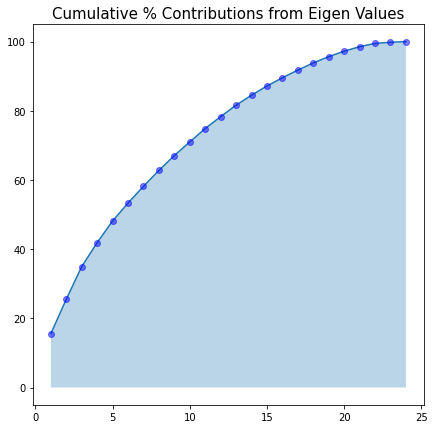

In [168]:
var_explained = [(i/sum(eigen_vals))*100 for i in eigen_vals]
cum_vx = np.cumsum(var_explained)

plt.figure(figsize=(7,7))
plt.title('Scree Plot',fontsize=15)
# plt.plot(range(1,len(var_explained)+1),var_explained)
plt.plot(range(1,len(var_explained)+1),var_explained,color='green',alpha=0.6, linewidth=2)
plt.plot(range(1,len(var_explained)+1),var_explained,'o')
plt.xlabel('Components',fontsize=10)
plt.ylabel('% Contributions from Eigen Values',fontsize=10)
plt.show()

plt.figure(figsize=(7,7))
plt.title('Cumulative % Contributions from Eigen Values',fontsize=15)
plt.plot(range(1,len(cum_vx)+1),cum_vx)
plt.fill_between(range(1,len(cum_vx)+1),cum_vx, alpha=0.3)
plt.plot(range(1,len(cum_vx)+1),cum_vx,'bo', alpha=0.5)
plt.show()

***
## **Question-2: [Linear Discriminant Analysis] :- [40 marks]**
Perform feature extraction using LDA on the aforementioned Dataset. Use any 2 classification
techniques of your choice and perform the classification.


1. Implement Linear Discriminant Analysis from scratch with the following subtasks:- \
a. A function for computing within class and between class scatter matrices \
b. A function that will automatically select the number of linear discriminants based
upon the percentage of variance that needs to be conserved [5+5 Marks]


In [169]:
def scatter_matrices(X,y):
    F = X.shape[1]
    Swc = np.zeros((F,F))
    classes = np.unique(y)
    C = len(classes)
    Sbc = np.zeros((F,F))
    mean_overall = np.mean(X, axis=0)
    for c in classes:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        Swc += (X_c - mean_c).T.dot((X_c - mean_c))
        n_c = X_c.shape[0]
        mean_diff = np.array(mean_c - mean_overall).reshape(F, 1)
        Sbc += n_c * (mean_diff).dot(mean_diff.T)

    return Swc, Sbc

def linear_discriminants(Swc, Sbc, thresh): # thresh is the threshold percentage of variance that need to ne conserved
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Swc).dot(Sbc))
    eigenvectors = eigenvectors.T
    idxs = np.argsort(abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[idxs]
    eigenvectors = eigenvectors[idxs]
    eigenvalues = np.abs(eigenvalues)

    sm = sum(eigenvalues.real)
    discr = [(i / sm) for i in sorted(eigenvalues.real, reverse=True)]
    cum_discr = np.cumsum(discr)
    num_components = 0
    sm=0
    for i in cum_discr:
        sm+=i
        num_components+=1
        if sm>=thresh:
            break
    lds = np.array(eigenvectors[0 : num_components])
    return lds, idxs

def LDA(X, lds):
    return  np.dot(X, lds.T).real


SWC, SBC = scatter_matrices(X_train,Y_train)
LDs, idxs_lda = linear_discriminants(SWC, SBC,0.9)
X_train_lda = LDA(X_train, LDs)


2. Perform PCA and compare the results with LDA [3 Marks]

In [170]:
Y_test = df_test['class']
X_test = df_test.drop(['class'],axis=1)
X_test_lda = LDA(X_test, LDs)

lda_model_dtc = DTC().fit(X_train_lda,Y_train)
lda_model_xgb = XGB().fit(X_train_lda,Y_train)
lda_model_rfc = RFC().fit(X_train_lda,Y_train)

lda_preds_dtc = lda_model_dtc.predict(X_test_lda)
lda_preds_xgb = lda_model_xgb.predict(X_test_lda)
lda_preds_rfc = lda_model_rfc.predict(X_test_lda)

lda_dtc_acc = metrics.accuracy_score(Y_test, lda_preds_dtc)
lda_xgb_acc = metrics.accuracy_score(Y_test, lda_preds_xgb)
lda_rfc_acc = metrics.accuracy_score(Y_test, lda_preds_rfc)

print('Metrics on Testing Data after applying LDA\n')
print(f'Accuracy = {lda_dtc_acc*100:.2f} %\t[ Decision Tree Classifier ]')
print(f'Accuracy = {lda_xgb_acc*100:.2f} %\t[ XGBoost Classifier ]')
print(f'Accuracy = {lda_rfc_acc*100:.2f} %\t[ Random Forest Classifier ]\n')

print('Metrics on Testing Data after applying PCA\n')
print(f'Accuracy = {pca_dtc_acc*100:.2f} %\t[ Decision Tree Classifier ]')
print(f'Accuracy = {pca_xgb_acc*100:.2f} %\t[ XGBoost Classifier ]')
print(f'Accuracy = {pca_rfc_acc*100:.2f} %\t[ Random Forest Classifier ]\n')

Metrics on Testing Data after applying LDA

Accuracy = 98.00 %	[ Decision Tree Classifier ]
Accuracy = 96.00 %	[ XGBoost Classifier ]
Accuracy = 98.00 %	[ Random Forest Classifier ]

Metrics on Testing Data after applying PCA

Accuracy = 92.00 %	[ Decision Tree Classifier ]
Accuracy = 96.00 %	[ XGBoost Classifier ]
Accuracy = 96.00 %	[ Random Forest Classifier ]




3. Identify features having a high impact on classification tasks using both PCA and LDA
and visualize the sample space using the first two principal components and first two
linear discriminants and comment your observations [2+5 Marks]

In [171]:
print('The descending order of feature indices having high impact is :\n')
print('For PCA : '+' '.join([str(x) for x in idxs_pca]))
print('For LDA : '+' '.join([str(x) for x in idxs_lda]))

print('\nWe see that first 5 features have maximum impact on classification common to both methods.')
print('These features are : '+', '.join([df.columns[i] for i in idxs_pca[:5]]))

The descending order of feature indices having high impact is :

For PCA : 0 1 2 3 4 7 9 11 19 20 21 23 22 18 17 16 15 14 13 12 10 8 6 5
For LDA : 0 1 2 3 4 5 6 7 8 10 9 11 12 13 14 15 16 17 18 19 20 22 21 23

We see that first 5 features have maximum impact on classification common to both methods.
These features are : family, steel, carbon, hardness, temper_rolling


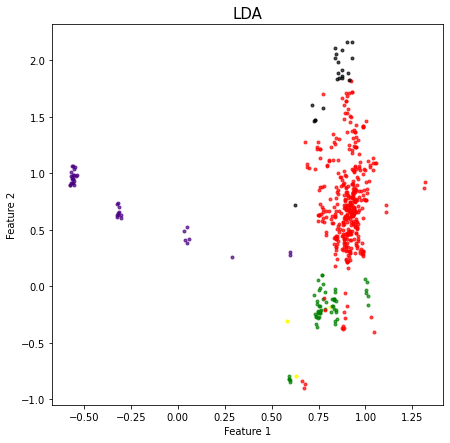

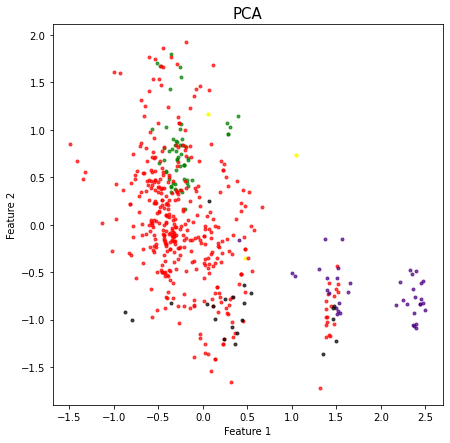

In [172]:
X_train_pcat = X_train_pca.T
X_train_ldat = X_train_lda.T

classes = np.unique(Y_train)
dummy1 = pd.DataFrame(Y_train)
dummy1['f1']=X_train_ldat[0]
dummy1['f2']=X_train_ldat[1]

dummy2 = dummy1.copy()
dummy2['f1']=X_train_pcat[0]
dummy2['f2']=X_train_pcat[1]


plt.figure(figsize=(7,7))
plt.title('LDA',fontsize=15)
colors=['yellow','green','red','indigo','black']
for i,c in enumerate(classes):
    cdf=dummy1[dummy1['class']==c]
    plt.plot(cdf['f1'],cdf['f2'],color=colors[i],marker='o',markersize=3,alpha=0.7, linestyle='')
    plt.xlabel('Feature 1',fontsize=10)
    plt.ylabel('Feature 2',fontsize=10)
plt.show()

plt.figure(figsize=(7,7))
plt.title('PCA',fontsize=15)
for i,c in enumerate(classes):
    cdf=dummy2[dummy2['class']==c]
    plt.plot(cdf['f1'],cdf['f2'],color=colors[i],marker='o',markersize=3,alpha=0.7, linestyle='')
    plt.xlabel('Feature 1',fontsize=10)
    plt.ylabel('Feature 2',fontsize=10)
plt.show()


4. Using any 2 classification techniques make a 2 * 2 table with column headers as
classification techniques used and row headers as feature extraction methods used.
The values inside the table should be the accuracy achieved in each case. Compare the
results of the table. [10 Marks]

In [173]:
table = [['',''],['','']]
table[0][0]=str(int(pca_dtc_acc*100))+' %'
table[0][1]=str(int(pca_rfc_acc*100))+' %'
table[1][0]=str(int(lda_dtc_acc*100))+' %'
table[1][1]=str(int(lda_rfc_acc*100))+' %'

table = pd.DataFrame(table)
table.columns = ['Decision Tree Classifier','Random Forest Classifier']
table.index = ['PCA','LDA']
table

,Decision Tree Classifier,Random Forest Classifier
PCA,92 %,96 %
LDA,98 %,98 %



5. Using LDA as a classifier, perform 5-fold cross-validation and plot ROC and compute
AUC for each fold from scratch [10 Marks]

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_curve, auc

lda_model = LDA()
ypreds = lda_model.fit(X_train,Y_train).predict(X_test)
Y_testb = preprocessing.LabelBinarizer().fit_transform(Y_test)
Y_trainb = pd.DataFrame(preprocessing.LabelBinarizer().fit_transform(Y_train))

X_partitions=[pd.DataFrame() for i in range(5)]
Y_partitions=[pd.DataFrame() for i in range(5)]

X_partitions[0]=X_train
Y_partitions[0]=Y_trainb
for i in range(0,4):
    X_partitions[i], X_partitions[i+1],Y_partitions[i], Y_partitions[i+1] = model_selection.train_test_split(X_partitions[i], Y_partitions[i], test_size=(5-i-1)/(5-i),random_state=41)

best_cv_model = None
cv_ytests = []
cv_probabs = []
best_acc = 0
all_acc = []

for i in range(5):
    cv_xtest = X_partitions[i]
    cv_ytest = np.array(Y_partitions[i])
    cv_xtrain = []
    cv_ytrain = []
    for j in range(5):
        if i==j:
            continue
        cv_xtrain.append(X_partitions[j])
        cv_ytrain.append(Y_partitions[j])
    cv_xtrain = pd.concat(cv_xtrain)
    cv_ytrain = pd.concat(cv_ytrain)
    
    curr_model = LDA()
    curr_model.fit(cv_xtrain, cv_ytrain)
    cv_ypredicted = curr_model.predict(cv_xtest)
    cv_probab = curr_model.predict_proba(cv_xtest)
    cv_ytests.append(cv_ytest)
    cv_probabs.append(cv_probab)
    curr_acc = metrics.accuracy_score(cv_ytest,cv_ypredicted)*100
    all_acc.append(curr_acc)

    if curr_acc>best_acc:
        best_acc = curr_acc
        best_cv_model = curr_model
        
print(f'After 5-fold cross-validation, maximum accuracy obtained on validation sets was :\nAccuracy = {best_acc:.2f} %\n')

cv_ypredicted = best_cv_model.predict(X_test)
cv_final_probab = best_cv_model.predict_proba(X_test)
acc_test = metrics.accuracy_score(Y_test, np.ravel(cv_ypredicted))*100

print('Metrics of price predictions on Testing data :')
print(f'Accuracy = {acc_test:.2f} %')

fpr, tpr, _ = roc_curve(Y_testb, cv_final_probab[:,1])
roc_auc = auc(fpr, tpr)

colors = ['red','purple','yellow','green','cyan']

plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color="navy",lw=2,label=f"ROC CV Testing (AUC = {roc_auc:0.2f})")
for i in range(1,6):
    cfpr, ctpr, _ = roc_curve(cv_ytests[i-1], cv_probabs[i-1][:,1])
    croc_auc = auc(cfpr, ctpr)
    plt.plot(cfpr,ctpr,color=colors[i-1],lw=1,label=f"ROC CV {i} (AUC = {croc_auc:0.2f})",alpha=0.6)

plt.plot([0, 1], [0, 1], color="black",linestyle='--',alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",fontsize=18)
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,8))
plt.plot([str(x) for x in range(1,6)],all_acc,c='darkorange',linestyle='--')
plt.scatter([str(x) for x in range(1,6)],all_acc,c='navy')
plt.xlabel('i-th Fold of CV')
plt.ylabel('Accuracy Score')
plt.title('Scores of 5-Fold CV',fontsize=18)
plt.show()

def top_class_p(all_probabs):
    l = []
    for i in all_probabs:
        l.append(max(i))
    l = np.array(l)
    return l

class_probs = top_class_p(cv_final_probab)
print('\nTop class probabbilities :\n')
plt.figure(figsize=(10,8))
plt.plot(range(len(class_probs)),class_probs,'go',markersize=4)
plt.xlabel('Index of Row')
plt.ylabel('Probability of Top Class')
plt.title('Top Class Probabilities',fontsize=18)
plt.ylim(0,1)
plt.show()